# Outline

1. Create SparkSession
2. Read tabular datasets
3. Dataframe API: SQL Projections and Filters
4. SQL API
5. Joins and Repartitions
6. Aggregations
7. Custom UDFs
8. Fancy stuff: working with time
9. Window functions

## Validate environment

In [1]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)


In [2]:
import pyspark
print(pyspark.__version__)

2.1.1+hadoop2.7


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


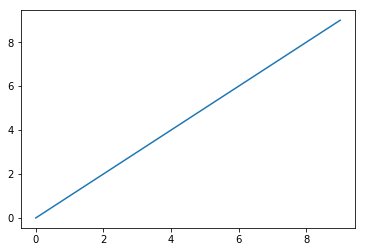

In [4]:
pylab.plot(range(10), range(10))

## Create SparkSession

In [5]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.Builder().getOrCreate()
spark.stop()

In [7]:
spark_config = SparkConf().setMaster("local[*]").setAppName("Spark SQL overview")
spark = SparkSession.Builder().config(conf=spark_config).getOrCreate()

In [8]:
spark._sc.getConf().getAll()

[('hive.metastore.warehouse.dir', 'file:/home/jovyan/spark-warehouse'),
 ('spark.driver.host', '172.17.0.2'),
 ('spark.driver.port', '34171'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1597088678730'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Spark SQL overview')]

## Reading Dataset (Movielens-100k Example)

Pipeline

```python
spark.read \
     .format(...) \
     .option(key, value) \
     .option(key, value) \
     .load(path)
```

Data source: https://grouplens.org/datasets/movielens/100k/

In [10]:
! head ml-100k/u.user

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067
4|24|M|technician|43537
5|33|F|other|15213
6|42|M|executive|98101
7|57|M|administrator|91344
8|36|M|administrator|05201
9|29|M|student|01002
10|53|M|lawyer|90703


### Q&A: what is "format", what are the "options"?

In [11]:
%%time
user_df = (
    spark.read
    .format("csv")
    .option("sep", "|")
    .load("ml-100k/u.user")
)

CPU times: user 2.33 ms, sys: 3.83 ms, total: 6.15 ms
Wall time: 6.5 s


In [12]:
user_df

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string]

In [13]:
user_df.show(1)

+---+---+---+----------+-----+
|_c0|_c1|_c2|       _c3|  _c4|
+---+---+---+----------+-----+
|  1| 24|  M|technician|85711|
+---+---+---+----------+-----+
only showing top 1 row



In [14]:
user_df.take(5)

[Row(_c0='1', _c1='24', _c2='M', _c3='technician', _c4='85711'),
 Row(_c0='2', _c1='53', _c2='F', _c3='other', _c4='94043'),
 Row(_c0='3', _c1='23', _c2='M', _c3='writer', _c4='32067'),
 Row(_c0='4', _c1='24', _c2='M', _c3='technician', _c4='43537'),
 Row(_c0='5', _c1='33', _c2='F', _c3='other', _c4='15213')]

### If there is a table, then there should be a schema

In [15]:
from pyspark.sql import types

In [16]:
schema = types.StructType(fields=[
    types.StructField("user_id", types.IntegerType()),
    types.StructField("age", types.IntegerType()),
    types.StructField("gender", types.StringType()),
    types.StructField("occupation", types.StringType()),
    types.StructField("zip", types.IntegerType()),
])

In [17]:
user_df = (
    spark.read
    .schema(schema)
    .format("csv")
    .option("sep", "|")
    .load("ml-100k/u.user")
)

In [18]:
user_df

DataFrame[user_id: int, age: int, gender: string, occupation: string, zip: int]

In [19]:
user_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zip: integer (nullable = true)



In [20]:
user_df.show(5)

+-------+---+------+----------+-----+
|user_id|age|gender|occupation|  zip|
+-------+---+------+----------+-----+
|      1| 24|     M|technician|85711|
|      2| 53|     F|     other|94043|
|      3| 23|     M|    writer|32067|
|      4| 24|     M|technician|43537|
|      5| 33|     F|     other|15213|
+-------+---+------+----------+-----+
only showing top 5 rows



In [22]:
# the following functionality is only available in Hadoop cluster installation
# user_df.summary().show()

Final version of reading Pipeline

```python
spark.read \
     .schema(...) \
     .format(...) \
     .option(key, value) \
     .option(key, value) \
     .load(path)
```

### Convenient Wrappers

In [23]:
user_df = spark.read.csv("ml-100k/u.user", schema=schema, sep="|")

In [25]:
user_df.show(2)

+-------+---+------+----------+-----+
|user_id|age|gender|occupation|  zip|
+-------+---+------+----------+-----+
|      1| 24|     M|technician|85711|
|      2| 53|     F|     other|94043|
+-------+---+------+----------+-----+
only showing top 2 rows



###  Tons of data sources with a unified API!
+ CSV
+ JSON
+ Hive
+ HBase
+ Cassandra
+ MySQL
+ PostgreSQL
+ Parquet
+ ORC
+ Kafka
+ ElasticSearch
+ Amazon S3
+ ...and more through custom connectors

Logs dataset: https://drive.google.com/drive/u/0/folders/1newx8_j2QU49dI8ogv-eWhvOylLpx7BO

In [28]:
! head -3 logsM.txt

In [29]:
log_schema = types.StructType(fields=[
    types.StructField("ip", types.StringType()),
    types.StructField("timestamp", types.LongType()),
    types.StructField("url", types.StringType()),
    types.StructField("size", types.IntegerType()),
    types.StructField("code", types.IntegerType()),
    types.StructField("ua", types.StringType()),
])

In [30]:
log_df = spark.read.csv("logsM.txt", sep="\t", schema=log_schema).cache()

In [31]:
log_df

DataFrame[ip: string, timestamp: bigint, url: string, size: int, code: int, ua: string]

In [32]:
log_df.rdd.getNumPartitions()

1

In [33]:
log_df = log_df.repartition(4)

In [34]:
log_df.rdd.getNumPartitions()

4

In [35]:
log_df.show(2, truncate=False)
# Spark 2.3+: vertical=True

+--------------+--------------+---------------------------+----+----+-------------------------------------------------------------------------------------------------------------+
|ip            |timestamp     |url                        |size|code|ua                                                                                                           |
+--------------+--------------+---------------------------+----+----+-------------------------------------------------------------------------------------------------------------+
|197.72.248.141|20140101020306|http://news.mail.ru/6344933|1412|203 |Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729;|
|222.131.187.37|20140101033837|http://news.mail.ru/8805842|1017|416 |Opera/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729;)               |
+--------------+--------------+---------------------------+----+----+-------------------------------

## Dataframe API: SQL Projections and Filters

Projection is a subset of columns

Filter is a asubset of rows

In [36]:
log_df.schema.fields
# Spark 2.3+:
# >> log.schema.fieldNames()
# ['ip', 'timestamp', 'url', 'size', 'code', 'ua']

[StructField(ip,StringType,true),
 StructField(timestamp,LongType,true),
 StructField(url,StringType,true),
 StructField(size,IntegerType,true),
 StructField(code,IntegerType,true),
 StructField(ua,StringType,true)]

In [37]:
log_df.select(["ip", "timestamp", "url"])

DataFrame[ip: string, timestamp: bigint, url: string]

In [38]:
log_df.select(["ip", "timestamp", "url"]).show(3)

+--------------+--------------+--------------------+
|            ip|     timestamp|                 url|
+--------------+--------------+--------------------+
|197.72.248.141|20140101020306|http://news.mail....|
|222.131.187.37|20140101033837|http://news.mail....|
|181.217.177.35|20140101052930|http://lenta.ru/4...|
+--------------+--------------+--------------------+
only showing top 3 rows



In [39]:
log_df.select("ip", "code").show(3)

+--------------+----+
|            ip|code|
+--------------+----+
|197.72.248.141| 203|
|222.131.187.37| 416|
|181.217.177.35| 100|
+--------------+----+
only showing top 3 rows



In [40]:
log_df.select("*").show(3)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|
|222.131.187.37|20140101033837|http://news.mail....|1017| 416|Opera/5.0 (compat...|
|181.217.177.35|20140101052930|http://lenta.ru/4...|1976| 100|Safari/5.0 compat...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 3 rows



In [41]:
log_df.select(log_df.ip, log_df.timestamp).show(3)

+--------------+--------------+
|            ip|     timestamp|
+--------------+--------------+
|197.72.248.141|20140101020306|
|222.131.187.37|20140101033837|
|181.217.177.35|20140101052930|
+--------------+--------------+
only showing top 3 rows



In [42]:
log_df.ip

Column<b'ip'>

### Aliasing

In [43]:
log_df.select(
    log_df.ip,
    log_df.code.alias("response_code")
).show(5)

+--------------+-------------+
|            ip|response_code|
+--------------+-------------+
|197.72.248.141|          203|
|222.131.187.37|          416|
|181.217.177.35|          100|
| 33.49.147.163|          422|
| 75.208.40.166|          415|
+--------------+-------------+
only showing top 5 rows



In [44]:
import pyspark.sql.functions as F

In [45]:
log_df.select(
    "ip",
    F.col("code").alias("response_code")
).show(5)

+--------------+-------------+
|            ip|response_code|
+--------------+-------------+
|197.72.248.141|          203|
|222.131.187.37|          416|
|181.217.177.35|          100|
| 33.49.147.163|          422|
| 75.208.40.166|          415|
+--------------+-------------+
only showing top 5 rows



### Good ol' Pandas

In [46]:
log_df[["ip", "code"]].show(5)

+--------------+----+
|            ip|code|
+--------------+----+
|197.72.248.141| 203|
|222.131.187.37| 416|
|181.217.177.35| 100|
| 33.49.147.163| 422|
| 75.208.40.166| 415|
+--------------+----+
only showing top 5 rows



In [47]:
log_df[[log_df.ip, log_df.code.alias("response_code")]].show(5)

+--------------+-------------+
|            ip|response_code|
+--------------+-------------+
|197.72.248.141|          203|
|222.131.187.37|          416|
|181.217.177.35|          100|
| 33.49.147.163|          422|
| 75.208.40.166|          415|
+--------------+-------------+
only showing top 5 rows



### Filtering

In [48]:
log_df.where("code == 200").show(3)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
| 75.208.40.166|20140104155237|http://news.rambl...|1307| 200|Opera/5.0 (compat...|
| 33.49.147.163|20140106045941|http://news.rambl...| 671| 200|Firefox/5.0 (comp...|
|110.91.102.196|20140108114835|http://news.mail....|1599| 200|Safari/5.0 (compa...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 3 rows



In [49]:
log_df.where(log_df.code == 200).show(3)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
| 75.208.40.166|20140104155237|http://news.rambl...|1307| 200|Opera/5.0 (compat...|
| 33.49.147.163|20140106045941|http://news.rambl...| 671| 200|Firefox/5.0 (comp...|
|110.91.102.196|20140108114835|http://news.mail....|1599| 200|Safari/5.0 (compa...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 3 rows



In [50]:
log_df.where(log_df.code == 200).show(3, truncate=False)

+--------------+--------------+------------------------------+----+----+----------------------------------------------------------------------------------------------------------+
|ip            |timestamp     |url                           |size|code|ua                                                                                                        |
+--------------+--------------+------------------------------+----+----+----------------------------------------------------------------------------------------------------------+
|75.208.40.166 |20140104155237|http://news.rambler.ru/9665982|1307|200 |Opera/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/12.0.742.112)            |
|33.49.147.163 |20140106045941|http://news.rambler.ru/1817681|671 |200 |Firefox/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729;)          |
|110.91.102.196|20140108114835|http://news.mail.ru/1314430   |1599|200 |Safari/5.0 (compatible; MSIE

In [51]:
log_df.where("code = 200 AND url LIKE '%rambler%'").show(3, truncate=False)

+---------------+--------------+------------------------------+----+----+-------------------------------------------------------------------------------------------------------------+
|ip             |timestamp     |url                           |size|code|ua                                                                                                           |
+---------------+--------------+------------------------------+----+----+-------------------------------------------------------------------------------------------------------------+
|135.124.143.193|20140106040300|http://news.rambler.ru/2362095|120 |200 |Safari/5.0 compatible; MSIE 9.0; Windows NT 7.0; Trident/5.0; .NET CLR 2.2.50767;)                           |
|33.49.147.163  |20140109011807|http://news.rambler.ru/9760079|4   |200 |Safari/5.0 (compatible; MSIE 9.0; Windows NT 8.0; WOW64; Trident/5.0; .NET CLR 2.7.40781; .NET4.0E; en-SG)   |
|197.72.248.141 |20140205145806|http://news.rambler.ru/1786267|1860|200 |Safari/

In [52]:
log_df.where(~log_df.code.isin([200, 400])).show(5)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|
|222.131.187.37|20140101033837|http://news.mail....|1017| 416|Opera/5.0 (compat...|
|181.217.177.35|20140101052930|http://lenta.ru/4...|1976| 100|Safari/5.0 compat...|
| 33.49.147.163|20140101065321|http://news.rambl...|1155| 422|Safari/5.0 (compa...|
| 75.208.40.166|20140101073934|http://lenta.ru/5...|1180| 415|Safari/5.0 (compa...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



In [53]:
log_df.where(~log_df.code.isin([200, 400]) & (log_df.url.like("%rambler%"))).show(5)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
|197.72.248.141|20140101034726|http://news.rambl...|2042| 428|Safari/5.0 (compa...|
|56.167.169.126|20140101073452|http://news.rambl...|1286| 414|Opera/5.0 (compat...|
|222.131.187.37|20140101132916|http://news.rambl...|1396| 105|Chrome/5.0 (Windo...|
|197.72.248.141|20140101200021|http://news.rambl...| 160| 426|Opera/5.0 (compat...|
| 75.208.40.166|20140101210547|http://news.rambl...|1571| 409|Chrome/5.0 (compa...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



### Good ol' Pandas

In [54]:
log_df[(log_df.code == 200) & (log_df.url.like("%rambler%"))].show(5)

+---------------+--------------+--------------------+----+----+--------------------+
|             ip|     timestamp|                 url|size|code|                  ua|
+---------------+--------------+--------------------+----+----+--------------------+
|135.124.143.193|20140106040300|http://news.rambl...| 120| 200|Safari/5.0 compat...|
|  33.49.147.163|20140109011807|http://news.rambl...|   4| 200|Safari/5.0 (compa...|
| 197.72.248.141|20140205145806|http://news.rambl...|1860| 200|Safari/5.0 (compa...|
| 197.72.248.141|20140222074905|http://news.rambl...|1264| 200|Chrome/5.0 compat...|
|  75.208.40.166|20140310132240|http://news.rambl...|1107| 200|Opera/5.0 (compat...|
+---------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



In [55]:
log_df[(log_df.code == 200) & (log_df.url.like("%rambler%"))][["ip", "timestamp"]].show(5)

+---------------+--------------+
|             ip|     timestamp|
+---------------+--------------+
|135.124.143.193|20140106040300|
|  33.49.147.163|20140109011807|
| 197.72.248.141|20140205145806|
| 197.72.248.141|20140222074905|
|  75.208.40.166|20140310132240|
+---------------+--------------+
only showing top 5 rows



## SQL API

In [56]:
sql_query = """
select ip, code from log_table 
where code = 200 and url LIKE '%rambler%'
"""

In [57]:
log_df.registerTempTable("log_table")

In [58]:
spark.sql(sql_query).show(3)

+---------------+----+
|             ip|code|
+---------------+----+
|135.124.143.193| 200|
|  33.49.147.163| 200|
| 197.72.248.141| 200|
+---------------+----+
only showing top 3 rows



## Functions

Three types:
+ mapping (1:1, similar to Hive UDF)
+ generating (1:(m)any, ~UDTF)
+ aggregating (m:1, UDAF)

In [59]:
log_df.select("ua", F.length("ua")).show(3)

+--------------------+----------+
|                  ua|length(ua)|
+--------------------+----------+
|Safari/5.0 (compa...|       109|
|Opera/5.0 (compat...|        94|
|Safari/5.0 compat...|        82|
+--------------------+----------+
only showing top 3 rows



In [60]:
log_df.select("ua", F.length("ua").alias("length")).show(3)

+--------------------+------+
|                  ua|length|
+--------------------+------+
|Safari/5.0 (compa...|   109|
|Opera/5.0 (compat...|    94|
|Safari/5.0 compat...|    82|
+--------------------+------+
only showing top 3 rows



In [61]:
log_df.select(F.concat("url", "?utf_medium=email")).show(3)

AnalysisException: "cannot resolve '`?utf_medium=email`' given input columns: [ip, url, timestamp, ua, size, code];;\n'Project [concat(url#89, '?utf_medium=email) AS concat(url, ?utf_medium=email)#973]\n+- Repartition 4, true\n   +- Relation[ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] csv\n"

In [62]:
(
log_df
    .select(F.concat("url", F.lit("?utf_medium=email")).alias("fixed_url"))
    .show(3, truncate=False)
)

+--------------------------------------------+
|fixed_url                                   |
+--------------------------------------------+
|http://news.mail.ru/6344933?utf_medium=email|
|http://news.mail.ru/8805842?utf_medium=email|
|http://lenta.ru/4386687?utf_medium=email    |
+--------------------------------------------+
only showing top 3 rows



### Explosions

In [63]:
log_df.select("ua", F.split("ua", " ").alias("word_list")).show(3, False)

+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+
|ua                                                                                                           |word_list                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+
|Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729;|[Safari/5.0, (compatible;, MSIE, 9.0;, Windows, NT, 6.1;, WOW64;, Trident/5.0;, .NET, CLR, 3.5.30729;, .NET, CLR, 3.0.30729;]|
|Opera/5.0 (compatible; MSIE 9.0; Windows NT 6.1

### Automagically, field selection works as it is in Python

In [64]:
log_df.select("ua", F.split("ua", " ")[0].alias("browser")).show(3)

+--------------------+----------+
|                  ua|   browser|
+--------------------+----------+
|Safari/5.0 (compa...|Safari/5.0|
|Opera/5.0 (compat...| Opera/5.0|
|Safari/5.0 compat...|Safari/5.0|
+--------------------+----------+
only showing top 3 rows



In [65]:
(
    log_df
    .select("ua", F.split("ua", " ").alias("word_list"))
    .withColumn("browser", F.col("word_list")[0])
    .show(3, False)
)

+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+----------+
|ua                                                                                                           |word_list                                                                                                                    |browser   |
+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+----------+
|Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729;|[Safari/5.0, (compatible;, MSIE, 9.0;, Windows, NT, 6.1;, WOW64;, Trident/5.0;, .NET, CLR, 3.5.30729;, .NET, CLR, 3.0.30729;]|Safari/5.0|
|Ope

In [66]:
(
    log_df
    .select("ua", F.split("ua", " ").alias("word_list"))
    .select(F.explode("word_list").alias("word"))
    .groupBy("word").count()
    .orderBy("count", ascending=False)
    .show(10)
)

+------------+-----+
|        word|count|
+------------+-----+
|     Windows|10092|
|        9.0;|10092|
|          NT|10092|
|        MSIE|10092|
|Trident/5.0;| 9121|
|         CLR| 8119|
|        .NET| 8119|
|(compatible;| 6033|
|      Win64;| 5085|
|        x64;| 5085|
+------------+-----+
only showing top 10 rows



## Joins and Repartitions

In [68]:
repartitioned_log_df = log_df.repartition(2, "ua")
log_df.rdd.getNumPartitions(), repartitioned_log_df.rdd.getNumPartitions()

(4, 2)

In [69]:
# specialized partitioner
log_df.repartition(3, F.col("ua") == "MSIE")

DataFrame[ip: string, timestamp: bigint, url: string, size: int, code: int, ua: string]

In [70]:
log_df.repartition(2, F.col("ua") == "MSIE").rdd.glom().map(lambda x: len(list(x))).collect()

[0, 10092]

In [71]:
log_df.repartition(2, "ua").rdd.glom().map(lambda x: len(list(x))).collect()

[5305, 4787]

In [72]:
! head -5 ipDataM.txt

49.105.15.79	Komi
110.91.102.196	Chelyabinsk Oblast
56.167.169.126	Saint Petersburg
75.208.40.166	Ulyanovsk Oblast
168.255.93.197	Irkutsk Oblast


In [73]:
ip_schema = types.StructType(fields=[
    types.StructField("ip", types.StringType()),
    types.StructField("region", types.StringType()),
])

In [74]:
ips_df = spark.read.csv("ipDataM.txt", sep="\t", schema=ip_schema).cache()

In [75]:
ips_df.show(3)

+--------------+------------------+
|            ip|            region|
+--------------+------------------+
|  49.105.15.79|              Komi|
|110.91.102.196|Chelyabinsk Oblast|
|56.167.169.126|  Saint Petersburg|
+--------------+------------------+
only showing top 3 rows



In [76]:
log_with_regions = log_df.join(ips_df, on="ip", how="inner")

In [77]:
log_with_regions.printSchema()

root
 |-- ip: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- url: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- code: integer (nullable = true)
 |-- ua: string (nullable = true)
 |-- region: string (nullable = true)



In [78]:
log_with_regions.show(3)

+--------------+--------------+--------------------+----+----+--------------------+----------------+
|            ip|     timestamp|                 url|size|code|                  ua|          region|
+--------------+--------------+--------------------+----+----+--------------------+----------------+
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|Zabaykalsky Krai|
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|  Stavropol Krai|
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|        Chechnya|
+--------------+--------------+--------------------+----+----+--------------------+----------------+
only showing top 3 rows



In [79]:
log_df.rdd.getNumPartitions()

4

In [80]:
log_with_regions.rdd.getNumPartitions()

4

In [82]:
log_with_regions.explain(extended=True)

== Parsed Logical Plan ==
'Join UsingJoin(Inner,Buffer(ip))
:- Repartition 4, true
:  +- Relation[ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] csv
+- Relation[ip#1317,region#1318] csv

== Analyzed Logical Plan ==
ip: string, timestamp: bigint, url: string, size: int, code: int, ua: string, region: string
Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318]
+- Join Inner, (ip#87 = ip#1317)
   :- Repartition 4, true
   :  +- Relation[ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] csv
   +- Relation[ip#1317,region#1318] csv

== Optimized Logical Plan ==
Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318]
+- Join Inner, (ip#87 = ip#1317)
   :- Repartition 4, true
   :  +- Filter isnotnull(ip#87)
   :     +- InMemoryRelation [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
   :           +- *FileScan csv [ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] Batched

## Let's compare with what we would have for big tables

In [83]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = 100500")

DataFrame[key: string, value: string]

In [84]:
log_with_regions = log_df.join(ips_df, on="ip", how="inner")

In [85]:
log_with_regions.rdd.getNumPartitions()

200

In [86]:
spark.conf.get("spark.sql.shuffle.partitions")

'200'

In [87]:
log_with_regions = log_with_regions.repartition(4).cache()

In [88]:
log_with_regions.explain(extended=True)

== Parsed Logical Plan ==
Repartition 4, true
+- Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318]
   +- Join Inner, (ip#87 = ip#1317)
      :- Repartition 4, true
      :  +- Relation[ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] csv
      +- Relation[ip#1317,region#1318] csv

== Analyzed Logical Plan ==
ip: string, timestamp: bigint, url: string, size: int, code: int, ua: string, region: string
Repartition 4, true
+- Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318]
   +- Join Inner, (ip#87 = ip#1317)
      :- Repartition 4, true
      :  +- Relation[ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] csv
      +- Relation[ip#1317,region#1318] csv

== Optimized Logical Plan ==
InMemoryRelation [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
   +- Exchange RoundRobinPartitioning(4)
      +- *Project [ip#87, timestamp#88L, url#89, size#90, code

### Query planner uses SortMergeJoin by default

### One more thing: broadcast hint

In [89]:
log_with_regions = log_df.join(F.broadcast(ips_df), on="ip", how="inner")
log_with_regions.explain()

== Physical Plan ==
*Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318]
+- *BroadcastHashJoin [ip#87], [ip#1317], Inner, BuildRight
   :- Exchange RoundRobinPartitioning(4)
   :  +- *Filter isnotnull(ip#87)
   :     +- InMemoryTableScan [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92], [isnotnull(ip#87)]
   :           +- InMemoryRelation [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
   :                 +- *FileScan csv [ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/logsM.txt], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<ip:string,timestamp:bigint,url:string,size:int,code:int,ua:string>
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, false]))
      +- *Filter isnotnull(ip#1317)
         +- InMemoryTableScan [ip#1317, region#1318], [isnotnull(ip#1317)]
      

In [90]:
# Spark 2.3+: Hint method for Dataframes
# log_with_regions = log_df.join(ips_df.hint("broadcast"), on="ip", how="inner").cache()

## Aggregations

Common Pipeline:
```python
df.groupBy(*cols)\
  .agg(*expressions)
```

In [91]:
(
log_with_regions
    .groupBy("region")
    .agg(F.count("ip").alias("count"))
    .show(10)
)

+-----------------+------+
|           region| count|
+-----------------+------+
|    Kaluga Oblast|111297|
|    Ryazan Oblast| 80716|
|  Smolensk Oblast| 99735|
|Sverdlovsk Oblast| 87004|
|          Mari El| 98414|
|   Irkutsk Oblast|113353|
|   Vologda Oblast|122363|
|    Kurgan Oblast| 86787|
|   Krasnodar Krai|102161|
|    Rostov Oblast| 95547|
+-----------------+------+
only showing top 10 rows



In [92]:
(
log_with_regions
    .groupBy("region")
    .agg(F.countDistinct("ip").alias("count"))
    .show(10)
)

+-----------------+-----+
|           region|count|
+-----------------+-----+
|    Kaluga Oblast|   15|
|    Ryazan Oblast|   14|
|  Smolensk Oblast|   14|
|Sverdlovsk Oblast|   15|
|          Mari El|   15|
|   Vologda Oblast|   14|
|   Irkutsk Oblast|   15|
|    Kurgan Oblast|   14|
|   Krasnodar Krai|   17|
|    Rostov Oblast|   15|
+-----------------+-----+
only showing top 10 rows



In [93]:
(
log_with_regions
    .groupBy("region")
    .count()
    .withColumnRenamed("count", "row_count")
    .show(10)
)

+-----------------+---------+
|           region|row_count|
+-----------------+---------+
|    Kaluga Oblast|   111297|
|    Ryazan Oblast|    80716|
|  Smolensk Oblast|    99735|
|Sverdlovsk Oblast|    87004|
|          Mari El|    98414|
|   Irkutsk Oblast|   113353|
|   Vologda Oblast|   122363|
|    Kurgan Oblast|    86787|
|   Krasnodar Krai|   102161|
|    Rostov Oblast|    95547|
+-----------------+---------+
only showing top 10 rows



In [94]:
(
log_with_regions
    .groupBy("region")
    .count()
    .withColumnRenamed("count", "row_count")
    .orderBy("row_count", ascending=False)
    .show(10)
)

+------------------+---------+
|            region|row_count|
+------------------+---------+
|  Ulyanovsk Oblast|   204275|
|            Jewish|   134523|
|  Saint Petersburg|   129362|
|Arkhangelsk Oblast|   124937|
|    Vologda Oblast|   122363|
|   Novgorod Oblast|   122306|
|     Moscow Oblast|   120336|
|  Krasnoyarsk Krai|   119285|
|              Komi|   117659|
|          Kalmykia|   117172|
+------------------+---------+
only showing top 10 rows



In [95]:
(
log_with_regions
    .groupBy(F.length("url").alias("url_length"))
    .agg(F.count("*").alias("row_count"))
    .orderBy("row_count", ascending=False)
    .show(10)
)

+----------+---------+
|url_length|row_count|
+----------+---------+
|        23|  1676363|
|        27|  1644000|
|        25|  1639043|
|        29|  1638174|
|        30|  1617023|
+----------+---------+



In [96]:
length_stat = (
    log_with_regions
    .groupBy(F.length("url").alias("url_length"))
    .agg(F.count("*").alias("row_count"))
    .orderBy("row_count", ascending=False)
    .toPandas()
)

In [97]:
length_stat.head()

,url_length,row_count
0,23,1676363
1,27,1644000
2,25,1639043
3,29,1638174
4,30,1617023


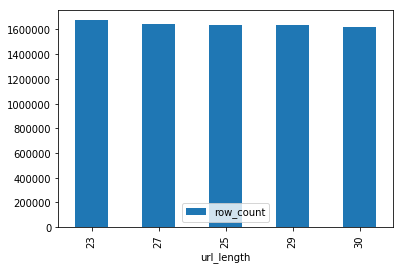

In [98]:
length_stat.plot.bar(x="url_length", y="row_count")

In [99]:
log_with_domains = (
    log_with_regions
    .withColumn("domain", F.regexp_extract("url", "http:\/\/(.*)\/", 1))
)
log_with_domains.show(3)

+--------------+--------------+--------------------+----+----+--------------------+----------------+------------+
|            ip|     timestamp|                 url|size|code|                  ua|          region|      domain|
+--------------+--------------+--------------------+----+----+--------------------+----------------+------------+
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|Zabaykalsky Krai|news.mail.ru|
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|  Stavropol Krai|news.mail.ru|
|197.72.248.141|20140101020306|http://news.mail....|1412| 203|Safari/5.0 (compa...|        Chechnya|news.mail.ru|
+--------------+--------------+--------------------+----+----+--------------------+----------------+------------+
only showing top 3 rows



In [100]:
length_stat = (
    log_with_domains
    .groupBy(F.length("url").alias("url_length"), "domain")
    .agg(F.count("*").alias("row_count"))
    .orderBy("row_count", ascending=False)
    .toPandas()
)
length_stat

,url_length,domain,row_count
0,23,lenta.ru,1676363
1,27,news.mail.ru,1644000
2,25,newsru.com,1639043
3,29,news.yandex.ru,1638174
4,30,news.rambler.ru,1617023


In [101]:
log_with_domains[log_with_domains.domain == "lenta.ru"][["url"]].show(5, False)

+-----------------------+
|url                    |
+-----------------------+
|http://lenta.ru/5276738|
|http://lenta.ru/5276738|
|http://lenta.ru/5276738|
|http://lenta.ru/5276738|
|http://lenta.ru/5276738|
+-----------------------+
only showing top 5 rows



## User Defined Functions

### Let us calculate correlation between url_length and domain type

The function type of the UDF can be one of the following:
+ **SCALAR**. A scalar UDF defines a transformation: One or more `pandas.Series` -> a `pandas.Series`. Scalar UDFs are used with `pyspark.sql.DataFrame.withColumn()` and `pyspark.sql.DataFrame.select()`
+ **GROUPED_MAP**. A grouped map UDF defines transformation: a `pandas.DataFrame` -> a `pandas.DataFrame`. Grouped map UDFs are used with `pyspark.sql.GroupedData.apply()`

In [102]:
log_with_domains[["domain"]].distinct().collect()

[Row(domain='news.rambler.ru'),
 Row(domain='news.yandex.ru'),
 Row(domain='newsru.com'),
 Row(domain='news.mail.ru'),
 Row(domain='lenta.ru')]

In [103]:
# Spark 2.3+, and pyarrow (can be installed with "pip install")

@F.pandas_udf(types.IntegerType())
def encode_domain(domains):
    mapping = {
        'lenta.ru': 0,
        'newsru.com': 1,
        'news.mail.ru': 2,
        'news.yandex.ru': 3,
        'news.rambler.ru': 4
    }
    return domains.apply(lambda x: mapping.get(x))


log_with_domains.withColumn("domain_digit", encode_domain("domain")).show(2, vertical=True)

(
    log_with_domains
    .withColumn("domain_encoded", encode_domain("domain"))
    .withColumn("url_length", F.length("url"))
    .corr("url_length", "domain_encoded")
)

AttributeError: module 'pyspark.sql.functions' has no attribute 'pandas_udf'

## Fancy stuff: working with time

Let us count number of days users visited our site

In [104]:
log_with_domains[["timestamp"]].show(3)

+--------------+
|     timestamp|
+--------------+
|20140101020306|
|20140101020306|
|20140101020306|
+--------------+
only showing top 3 rows



In [105]:
log_with_domains.withColumn("ts", F.unix_timestamp("timestamp", "yyyyMMddHHmmss")).show(3)

AnalysisException: "cannot resolve 'unix_timestamp(`timestamp`, 'yyyyMMddHHmmss')' due to data type mismatch: argument 1 requires (string or date or timestamp) type, however, '`timestamp`' is of bigint type.;;\n'Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318, domain#2028, unix_timestamp(timestamp#88L, yyyyMMddHHmmss) AS ts#2283]\n+- Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318, regexp_extract(url#89, http:\\/\\/(.*)\\/, 1) AS domain#2028]\n   +- Project [ip#87, timestamp#88L, url#89, size#90, code#91, ua#92, region#1318]\n      +- Join Inner, (ip#87 = ip#1317)\n         :- Repartition 4, true\n         :  +- Relation[ip#87,timestamp#88L,url#89,size#90,code#91,ua#92] csv\n         +- BroadcastHint\n            +- Relation[ip#1317,region#1318] csv\n"

In [106]:
log_with_unixtimestamp = (
    log_with_domains
    .withColumn("ts", F.unix_timestamp(F.col("timestamp").cast("string"), "yyyyMMddHHmmss"))
    .drop("timestamp", "url", "size", "code", "ua", "region", "domain")
)

log_with_unixtimestamp.show(3)

+--------------+----------+
|            ip|        ts|
+--------------+----------+
|197.72.248.141|1388541786|
|197.72.248.141|1388541786|
|197.72.248.141|1388541786|
+--------------+----------+
only showing top 3 rows



In [107]:
(
log_with_unixtimestamp
    .groupBy("ip")
    .agg(F.min("ts").alias("begin"), F.max("ts").alias("end"))
    .select("ip", (F.col("end") - F.col("begin")).alias("seconds_overall"))
    .select("ip", (F.col("seconds_overall") / 60.0 / 60.0 / 24.0).alias("days"))
    .show(5)
)

+--------------+------------------+
|            ip|              days|
+--------------+------------------+
|  3.183.113.77|115.00466435185184|
|168.255.93.197|115.05512731481481|
|222.131.187.37|115.40369212962963|
|56.167.169.126|114.50332175925926|
| 33.49.147.163|115.72543981481482|
+--------------+------------------+
only showing top 5 rows



## Window functions

Let us count the amount of user's sessions

In [110]:
from pyspark.sql import Window

(
log_with_unixtimestamp
    .select("ip", "ts", F.count("*").over(Window.partitionBy("ip")).alias("count"))
    .orderBy("count")
    .show(10)
)

+------------+----------+-----+
|          ip|        ts|count|
+------------+----------+-----+
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
|25.62.10.220|1388835012| 7020|
+------------+----------+-----+
only showing top 10 rows



In [112]:
# user_window = Window.orderBy("ts").partitionBy("ip")
user_window = Window.partitionBy("ip").orderBy("ts")

In [113]:
(
    log_with_unixtimestamp.select(
        "ip",
        "ts",
        F.row_number().over(user_window).alias("row_number"),
        F.lag("ts").over(user_window).alias("lag"),
        F.lead("ts").over(user_window).alias("lead"),
    )
    .show(10)
)

+------------+----------+----------+----------+----------+
|          ip|        ts|row_number|       lag|      lead|
+------------+----------+----------+----------+----------+
|3.183.113.77|1388594462|         1|      null|1388594462|
|3.183.113.77|1388594462|         2|1388594462|1388594462|
|3.183.113.77|1388594462|         3|1388594462|1388594462|
|3.183.113.77|1388594462|         4|1388594462|1388594462|
|3.183.113.77|1388594462|         5|1388594462|1388594462|
|3.183.113.77|1388594462|         6|1388594462|1388594462|
|3.183.113.77|1388594462|         7|1388594462|1388594462|
|3.183.113.77|1388594462|         8|1388594462|1388594462|
|3.183.113.77|1388594462|         9|1388594462|1388594462|
|3.183.113.77|1388594462|        10|1388594462|1388594462|
+------------+----------+----------+----------+----------+
only showing top 10 rows



In [114]:
(
log_with_unixtimestamp
    .select("ip", "ts", F.lead("ts").over(user_window).alias("lead"))
    .select("ip", "ts", (F.col("lead") - F.col("ts")).alias("diff"))
    .where("diff > 60 * 30 or diff IS NULL")
    .groupBy("ip")
    .count()
    .orderBy(F.col("count").desc())
    .show(30)
)

+---------------+-----+
|             ip|count|
+---------------+-----+
|  75.208.40.166| 1363|
| 197.72.248.141| 1101|
|  33.49.147.163|  993|
| 222.131.187.37|  711|
|135.124.143.193|  653|
| 168.255.93.197|  589|
| 56.167.169.126|  579|
|   49.203.96.67|  526|
|   49.105.15.79|  480|
| 110.91.102.196|  362|
|247.182.249.253|  270|
| 231.119.88.198|  207|
|   25.62.10.220|  152|
| 181.217.177.35|  137|
| 168.146.187.80|  104|
|   3.183.113.77|   99|
|    14.8.59.211|   57|
+---------------+-----+



In [115]:
%%time
log_with_unixtimestamp.coalesce(1).write.csv("log_with_unixtimestamp.csv", sep="\t")

CPU times: user 1.44 ms, sys: 2.55 ms, total: 3.99 ms
Wall time: 18.6 s


In [116]:
%%time
log_with_unixtimestamp.write.csv("log_with_unixtimestamp_no_coal.csv", sep="\t")

CPU times: user 10.5 ms, sys: 4.99 ms, total: 15.5 ms
Wall time: 12.5 s


In [117]:
spark.stop()